In [ ]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')

# Personalized path to your project directory
path = '/content/drive/MyDrive/cod/LEA3_helath' # Replace with your actual path

# Add the path to sys.path
sys.path.append(path)
os.chdir(path)

os.curdir



Mounted at /content/drive


'.'

In [ ]:
import numpy as np
import joblib ### para cargar array

########Paquetes para NN #########

from sklearn import metrics ### para analizar modelo
from sklearn.ensemble import RandomForestClassifier  ### para analizar modelo
import pandas as pd

from sklearn import tree
import tensorflow as tf


import cv2 ### para leer imagenes jpeg
### pip install opencv-python

from matplotlib import pyplot as plt #

from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:

x_train = joblib.load('salidas/x_train.pkl')
y_train = joblib.load('salidas/y_train.pkl')
x_test = joblib.load('salidas/x_test.pkl')
y_test = joblib.load('salidas/y_test.pkl')

In [ ]:
##############################################################################
################ Preprocesamiento  para modelos Shallow learning ##############
##############################################################################

x_train.shape
y_train.shape

##### convertir a 1 d array ############
x_train2=x_train.reshape(5216,30000)
x_test2=x_test.reshape(624, 30000)
x_train2.shape
x_test2.shape

x_train2[1]


array([18, 18, 18, ...,  0,  0,  0], dtype=uint8)

In [ ]:


############################################################
###############Seleccionar un indicador ################
############################################################

### Precision Tasa de acierto en predichos positivos ( qué porcentaje de personas identificada con neumonía realmente tienen)
### Recall: Tasa de identficación de positivos (de los que tenían neumonía cuantos predije tenían)
### F1_Socre: Combina Precions y recall (promedio entre dos anteriores)
### Acurracy: Porcentaje de acertados
### AUC: detección de positivos vs mala clasificaicón de negativos: porcentaje de los que neumonía que identifico vs los normales que digo que tiene neumonía

############Analisis problema ###########
#### me interesa recall: de los enfermos que los pueda detectar, sin embargo
#### el problema es que puede generar mucho trabajo porque clasifica a
####la mayoria como con neumonía, entonces usaremos el AUC que mide la capacidad e clasificación de neumoinía en balance con los noramles mal calsificados


In [ ]:

############################################################
################ Probar modelos de tradicionales#########
############################################################

#################### RandomForest ##########

rf=RandomForestClassifier()
rf.fit(x_train2, y_train)

pred_train=rf.predict(x_train2)
print(metrics.classification_report(y_train, pred_train))


pred_test=rf.predict(x_test2)
print(metrics.classification_report(y_test, pred_test))

print(metrics.roc_auc_score(y_train, pred_train))
print(metrics.roc_auc_score(y_test, pred_test))

cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Pneu', 'Normal'])
disp.plot()

In [ ]:
#################### Decsion tree##########

clf_dt= tree.DecisionTreeClassifier()
clf=clf_dt.fit(x_train2, y_train)

pred_train=clf_dt.predict(x_train2)
print(metrics.classification_report(y_train, pred_train))
metrics.roc_auc_score(y_train, pred_train)

pred_test=clf_dt.predict(x_test2)
print(metrics.classification_report(y_test, pred_test))
metrics.roc_auc_score(y_test, pred_test)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1341
           1       1.00      1.00      1.00      3875

    accuracy                           1.00      5216
   macro avg       1.00      1.00      1.00      5216
weighted avg       1.00      1.00      1.00      5216

              precision    recall  f1-score   support

           0       0.82      0.34      0.48       234
           1       0.71      0.96      0.81       390

    accuracy                           0.73       624
   macro avg       0.77      0.65      0.65       624
weighted avg       0.75      0.73      0.69       624



np.float64(0.6491452991452993)

In [ ]:
############################################################
################ Probar modelos de redes neuronales #########
############################################################

fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


checkpoint = ModelCheckpoint(
    filepath='salidas/best_model_auc.keras',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)

##### configura el optimizador y la función para optimizar ##############

fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Recall', 'Precision'])


#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=checkpoint)


#########Evaluar el modelo ####################
test_loss, test_acc, test_auc, test_recall, test_precision = fc_model.evaluate(x_test, y_test, verbose=2)
print("Test auc:", test_auc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - AUC: 0.6174 - Precision: 0.8093 - Recall: 0.7896 - accuracy: 0.7020 - loss: 338.2444
Epoch 1: val_AUC improved from -inf to 0.81617, saving model to salidas/best_model_auc.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - AUC: 0.6214 - Precision: 0.8111 - Recall: 0.7920 - accuracy: 0.7052 - loss: 331.0190 - val_AUC: 0.8162 - val_Precision: 0.8285 - val_Recall: 0.9538 - val_accuracy: 0.8478 - val_loss: 19.3839
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - AUC: 0.8136 - Precision: 0.9031 - Recall: 0.8971 - accuracy: 0.8520 - loss: 31.2524
Epoch 2: val_AUC did not improve from 0.81617
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - AUC: 0.8138 - Precision: 0.9032 - Recall: 0.8973 - accuracy: 0.8522 - loss: 31.2089 - val_AUC: 0.5235 - val_Precision: 0.6362 - val_Recall: 1.0000 - val_accuracy: 0.6426 - val_loss: 221.4555
Epoch 3/10
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - AUC: 0.7716 - Precision: 0.8809 - Recall: 0.9119 - accuracy: 0.840

In [ ]:
best_auc=tf.keras.models.load_model('salidas/best_model_auc.keras')
test_loss, test_acc, test_auc, test_recall, test_precision = best_auc.evaluate(x_test, y_test, verbose=2)
print("Test auc:", test_auc)

20/20 - 4s - 192ms/step - AUC: 0.8375 - Precision: 0.8820 - Recall: 0.8436 - accuracy: 0.8317 - loss: 23.8386
Test auc: 0.8375301361083984


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       234
           1       0.88      0.84      0.86       390

    accuracy                           0.83       624
   macro avg       0.82      0.83      0.82       624
weighted avg       0.84      0.83      0.83       624



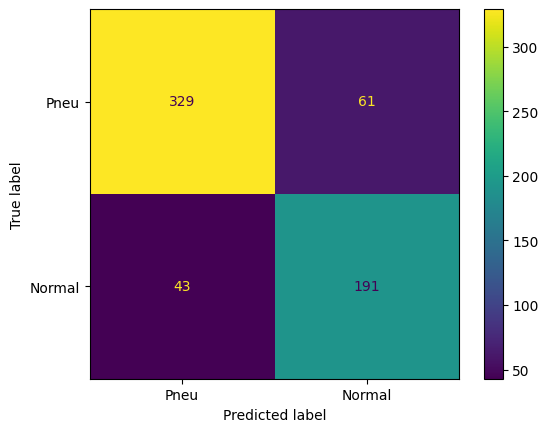

In [ ]:
###### matriz de confusión test
pred_test=(best_auc.predict(x_test) > 0.9).astype('int')
cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Pneu', 'Normal'])
disp.plot()

print(metrics.classification_report(y_test, pred_test))



